## Множественное тестирование: теория и практика

Если аудитория разбивается более чем на две подгруппы, вероятность получить ошибку первого рода при эксперименте нарастает экспоненциально:

***FWER*** = $1 – (1 – \alpha)^n, $

где $n$ - количество проверяемых гипотез, $ alpha $ - заданный уровень статистической значимости.

Family-Wise Error Rate - вероятность совершения хотя бы одной ошибки первого рода по всем проверкам гипотез.

***Проблема множественного тестирования*** - распространенная проблема в статистике, которая возникает при одновременном проведении нескольких проверок гипотез на одном наборе данных, либо же когда в тесте есть множество метрик для принятия решений
* При этом неправильно интерпретируются результаты без учета повышенной вероятности получения ложноположительных результатов (ошибка 1 рода).
* Растет кумулятивная ошибка первого рода (FWER).


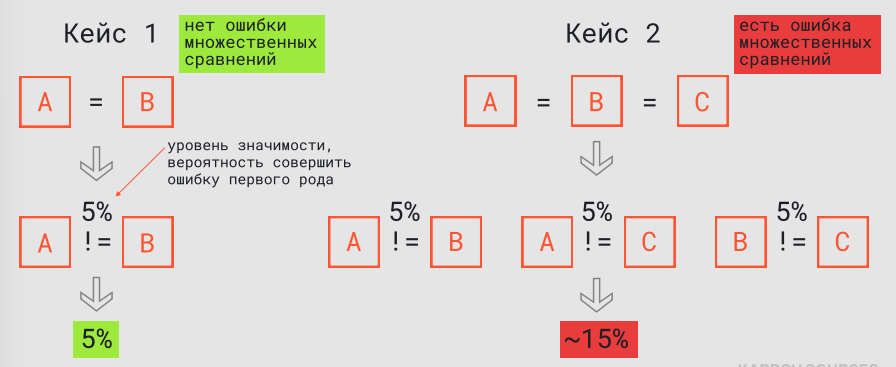

***Зачем тогда проводятся множественные эксперименты?***
* Требуется протестировать несколько изменений и их коммулятивное воздействие на продуктовые метрики
* Изменения можно протестировать только в одном временно́м промежутке, поскольку они и взаимозависимы, и чувствительны к недельной сезонности.
* Заказчик хочет как можно скорее и дешевле получить ответ, какой из вариантов следует выбрать, сэкономив при этом время разработки и внедрения эксперимента.

### Способы считать ошибки. FDP и FDR
При проверке множества гипотез Confusion matrix будет выглядеть следующим образом со следующими ошибками:

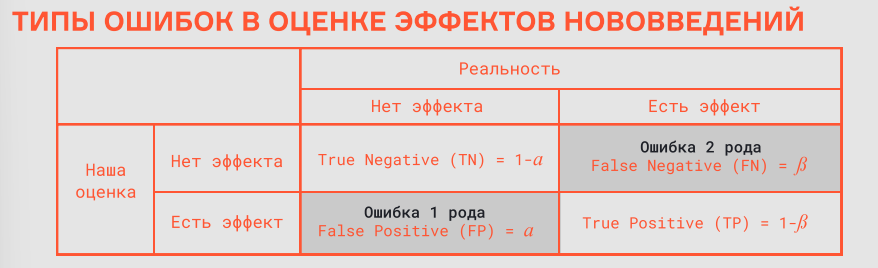

***FDP(False Discovery Proportion)*** - доля ложных отклонений гипотез.
***FDR (False Discovery Rate)*** - мат. ожидание доли ложных отклонений гипотез.

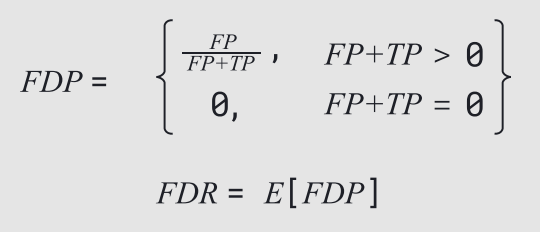

***Разница между FWER и FDR***
* FWER и FDR - способ понимать, стали ли мы чаще ошибаться из-за множественных сравнений.
* Методы контроля ошибки FWER часто приводит к потере мощности тестов. Это значит, что мы начинаем видеть стат. значимость только у самых сильных изменений.
* Методы контроля FDR позволяют повышать мощность эксперимента, а это значит, что мы меньше пропускаем работающие фичи.

***Резюмируем***
* Если нам важно сделать как можно меньше ложных открытий (FP), то с этим лучше справляются FWER методики контроля
* Если нам важно пропускать как можно меньше истинных (FN), то для этого лучше подходят FDR методики контроля - они имеют большую мощность

## Решение проблемы множественной проверки гипотез

***Существует множество методов поправок:***
* Бонферрони (Bonferroni)(FWER)
* Холма-Бонферрони (Holm–Bonferroni)(FWER)
* Шидака (Šidák)(FWER)
* Бенджамини-Хохберга (Benjamini-Hochberg)(FDR)
* Тьюки (Tukey)
* Даннета (Dunnett)
* Шеффе (Scheffé)

### Бонферрони
Поправка Бонферрони — простая и интуитивно понятная поправка для FWER. 

Подсчитывается скорректированный alpha:
$\alpha' = \alpha/k$,

$k$ - количество проверяемых гипотез

### Холма-Бонферрони

Поправка Холма-Бонферрони — улучшенный вариант поправки Бонферрони,
который имеет больше мощности.

Метод работает следующим образом:
1. Сортировка от меньшего к большему p-value для каждой проверяемой гипотезы
2. Скоректированный alpha считается следующим образом:
$$\alpha{_i} = \alpha / n -i +1$$
3. Проверка каждой гипотезы, если p-value меньше скоректированного $\alpha$, то нулевая гипотеза отклоняется, если выше или равно $\alpha$, то начиная с этой гипотезы и далее - принимается

### Шидака
Метод Шидака — очень прост в реализации и похож на метод Бонферрони,
поправка менее строгая, чем Бонферрони, но лишь незначительно. 

Скорректированный alpha считается так:
$$\alpha' = 1 - (1 - \alpha)^{1/k} $$

$k$ - количество проверяемых гипотез

### Бенджамини-Хохберга
Поправка Бенджамини-Хохберга позволяет контролировать FDR, когда мы
ошибочно говорим, что эффект есть, хотя его на самом деле нет, от всех
значимых эффектов. 

Реализация похожа на метод Холма-Бонферрони:
1. Сортировка от меньшего к большему p-value для каждой проверяемой гипотезы
2. Скоректированный $\alpha$ считается следующим образом: $$ \alpha{_i} = \alpha*i / n$$
3. Принимает или отвергаем нулевую гипотезу в зависимости от p-value

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.multitest import multipletests
import seaborn as sns
plt.style.use('ggplot')

# Запустим базовый ttest на проверку одной гипотезы
Будем использовать его как baseline для сравнения

Просчитаем дизайн эксперимента, сколько нужно в каждой группе для двусторонней проверки гипотез с помощью t-test'а при MDE в 1%, если у нас распределение со средним 10, и стандартным отклонением 2. Для alpha и beta равным 0.05 и 0.2 соответсвенно

In [ ]:
mean, std = 10, 2
alpha = 0.05
power = 0.8
lift = 0.01
effect_size = mean * lift / std

control_mean, control_std = mean, std
test_mean, test_std = mean * (1 + lift), std
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, alternative = 'two-sided'))#*2

alpha = 0.05
beta = 0.2

n_tests = 10000

p_values_ab_alpha = []

def run_ab_test(i):
    values_A = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)
    values_B = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)

    t_stat_ab, p_value_ab = ttest_ind(values_A, values_B, alternative='two-sided')

    return p_value_ab

results = Parallel(n_jobs=-1)(delayed(run_ab_test)(i) for i in tqdm(range(n_tests)))

for result in results:
    p_values_ab_alpha.append(result)

alpha_ttest_ab = np.where(np.array(p_values_ab_alpha) < alpha)[0].shape[0] / n_tests

print('Alpha for t-test two-sided for AB =', alpha_ttest_ab)

  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha for t-test two-sided for AB = 0.0466


С помощью симуляции можно убедиться в том, что alpha сохраняется в том уровне, который мы заранее подсчитали

In [ ]:
mean, std = 10, 2
alpha = 0.05
power = 0.8
lift = 0.01
effect_size = mean * lift / std

control_mean, control_std = mean, std
test_mean, test_std = mean * (1 + lift), std
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, alternative = 'two-sided'))#*2

alpha = 0.05
beta = 0.2

n_tests = 10000

p_values_ab_beta = []

def run_ab_test(i):
    values_A = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)
    values_B = np.random.normal(loc=test_mean, scale=test_std, size=sample_size)

    t_stat_ab, p_value_ab = ttest_ind(values_A, values_B, alternative='two-sided')

    return p_value_ab

results = Parallel(n_jobs=-1)(delayed(run_ab_test)(i) for i in tqdm(range(n_tests)))

for result in results:
    p_values_ab_beta.append(result)

power_ttest_ab = np.where(np.array(p_values_ab_beta) < alpha)[0].shape[0] / n_tests

print('Power for t-test two-sided for AB =', power_ttest_ab)

  0%|          | 0/10000 [00:00<?, ?it/s]

Power for t-test two-sided for AB = 0.8015


То же самое касается и мощности, при кейсе когда MDE равен реальному эффекту

## Давайте прогоним АВС-тест

### Давайте посмотрим как ведет себя ALPHA

In [ ]:
mde = 0.01
lift = 0.01
control_mean, control_std = mean, std
test_mean, test_std = mean * (1 + lift), std
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, alternative = 'two-sided'))#*2

alpha = 0.05
beta = 0.2

n_tests = 10000

p_values_abc_alpha = []

def run_ab_test(i):
    values_A = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)
    values_B = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)
    values_C = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)

    t_stat_ab, p_value_ab = ttest_ind(values_A, values_B, alternative='two-sided')
    t_stat_ac, p_value_ac = ttest_ind(values_A, values_C, alternative='two-sided')
    t_stat_bc, p_value_bc = ttest_ind(values_B, values_C, alternative='two-sided')

    return p_value_ab, p_value_ac, p_value_bc

results = Parallel(n_jobs=-1)(delayed(run_ab_test)(i) for i in tqdm(range(n_tests)))

for result in results:
    p_values_abc_alpha.append(result)

alpha_ttest_abc = np.where(np.array(p_values_abc_alpha) < alpha)[0].shape[0] / n_tests

print('Alpha t-test two-sided for ABC =', alpha_ttest_abc)

  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha t-test two-sided for ABC = 0.1562


Как мы видим ошибка первого рода действительно выросла до примерно 15%. Это грустно. Будем учиться это исправлять.

### Давайте посмотрим как ведет себя POWER

Давайте рассмотрим вариант когда в тесте есть две "прокрашенных" гипотезы

In [ ]:
mde = 0.01
lift = 0.01
control_mean, control_std = mean, std
test_mean, test_std = mean * (1 + lift), std
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, alternative = 'two-sided'))#*2

alpha = 0.05
beta = 0.2

n_tests = 10000

p_values_abc_power = []

def run_ab_test(i):
    values_A = np.random.normal(loc=control_mean, scale=control_std, size=sample_size)
    values_B = np.random.normal(loc=test_mean, scale=test_std, size=sample_size)
    values_C = np.random.normal(loc=test_mean, scale=test_std, size=sample_size) # эффект добавим только

    t_stat_ab, p_value_ab = ttest_ind(values_A, values_B, alternative='two-sided')
    t_stat_ac, p_value_ac = ttest_ind(values_A, values_C, alternative='two-sided')
    t_stat_bc, p_value_bc = ttest_ind(values_B, values_C, alternative='two-sided')

    return p_value_ab, p_value_ac, p_value_bc

results = Parallel(n_jobs=-1)(delayed(run_ab_test)(i) for i in tqdm(range(n_tests)))

for result in results:
    p_values_abc_power.append(result)

lt_alpha = np.array(p_values_abc_power) < alpha

power_ttest_abc = len(lt_alpha[np.logical_and(lt_alpha[:, 0], lt_alpha[:, 1])]) / n_tests

print('Power for t-test two-sided for ABC =', power_ttest_abc)

  0%|          | 0/10000 [00:00<?, ?it/s]

Power for t-test two-sided for ABC = 0.6953


При варианте с двумя прокрашенными гипотезами у нас рост кумуллятивной ошибки второго рода (когда дожен задетектить оба эффекта, иначе выдается ошибка) работает по той же логике, что и рост FWER альфа.

**Бороться с этим можно тем, что придется в тесты со множественными проверками гипотез закладывать большие размеры выборок.**

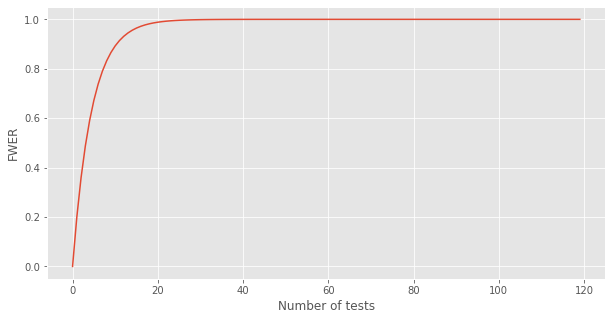

In [ ]:
# график роста FWER
alpha = 0.05
beta = 0.2
x = np.arange(120)
y = 1 - ((1 - beta) ** x)
plt.figure(figsize = (10, 5))
plt.ylabel('FWER')
plt.xlabel('Number of tests')
plt.plot(x, y);

Это график роста групповой ошибки первого рода (alpha), с ростом кол-ва проверяемых гипотез. В один из моментов, у нас ~100% шанса можно обнаружить значимый эффект

# Способы избавиться от роста ошибки первого рода

## метод Бонферонни

In [ ]:
a_bonf = alpha / 3

alpha_ttest_abc_bonf = np.where(np.array(p_values_abc_alpha) < a_bonf)[0].shape[0] / n_tests

print('Alpha до поправки =', alpha_ttest_abc)
print('Alpha после поправки =', alpha_ttest_abc_bonf)

Alpha до поправки = 0.1562
Alpha после поправки = 0.054


Так же существуют готовые реализации например из библиотеки statsmodels:
https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

С помощью готовой библиотеки statsmodels, алгоритм возможно более трудозатратны. Но возвращает те же значения, что и самописная реализация.

Имплементация для поправки Бонферрони для alpha

In [ ]:
# посмотрим как ведет себя FWER при применении поправки Бонферрони

sorted_p_vals_abc = np.sort(np.array(p_values_abc_alpha))

hyps = np.zeros((sorted_p_vals_abc.shape[0], sorted_p_vals_abc.shape[1]))
for i in range(len(p_values_abc_alpha)):
    hyps[i] = multipletests(p_values_abc_alpha[i], alpha = 0.05, method = 'bonferroni')[0]
print('Alpha после поправки =', np.where(hyps == 1)[0].shape[0] / n_tests)

Alpha после поправки = 0.054


In [ ]:
# посмотрим как ведет себя мощность при применении поправки Бонферрони
lt_alpha = np.array(p_values_abc_power) < a_bonf

power_ttest_abc_bonf = len(lt_alpha[np.logical_and(lt_alpha[:, 0], lt_alpha[:, 1])]) / n_tests

print('Power до поправки =', power_ttest_abc)
print('Power после поправки =', power_ttest_abc_bonf)

Power до поправки = 0.6953
Power после поправки = 0.5077


Бонферони возвращает альфа в заданные границы, но за это приходится жертвовать большой потерей мощности. Посмотрим как работают другие методики с мощностью и альфа.

## Холма-Бонферонни

In [ ]:
# посмотрим как ведет себя FWER при применении поправки Холма-Бонферрони

sorted_p_vals_abc = np.sort(np.array(p_values_abc_alpha)) # Делаем сортировку p-value значения гипотез

n = sorted_p_vals_abc.shape[1] # кол-во гипотез
rank = range(1, n + 1)
alphas_hb = [(alpha / (n - r + 1)) for r in rank] # считаем скорректированные alpha

# Дальше пытаемся для 10 тыс. симуляции проверить нулевую гипотезу
reject_null_hyp = 0
rejects = []

for i in range(sorted_p_vals_abc.shape[0]):
    for j in range(sorted_p_vals_abc.shape[1]):
        if sorted_p_vals_abc[i][j] >= alphas_hb[j]: # 3 - ий пункт со слайда
            break
        else:
            reject_null_hyp += 1
    rejects.append(reject_null_hyp)
    reject_null_hyp = 0

n_rejects_null_hyp_hb = sum(rejects) # Кол-во ложноположительных гипотез
n_tests_hb = sorted_p_vals_abc.shape[0]

print('Alpha до поправки =', alpha_ttest_abc)
print('Alpha после поправки =', n_rejects_null_hyp_hb / n_tests_hb)

Alpha до поправки = 0.1562
Alpha после поправки = 0.0574


С альфа в этом методе тоже все нормально

In [ ]:
# посмотрим как ведет себя мощность при применении поправки Холма-Бонферрони

sorted_p_vals_abc = np.sort(np.array(p_values_abc_power))

n = sorted_p_vals_abc.shape[1]
rank = range(1, n + 1)
alphas_hb = [(alpha / (n - r + 1)) for r in rank]

reject_null_hyp = 0
rejects = []

for i in range(sorted_p_vals_abc.shape[0]):
    for j in range(sorted_p_vals_abc.shape[1]):
        if sorted_p_vals_abc[i][j] >= alphas_hb[j]:
            break
        else:
            reject_null_hyp += 1
    rejects.append(reject_null_hyp)
    reject_null_hyp = 0

n_rejects_null_hyp_hb = np.where(np.array(rejects) == 2)[0].shape[0] # Ищем отвергнутые 2 нулевые гипотезы из 3 - х гипотез
n_tests_hb = sorted_p_vals_abc.shape[0]

correction_for_power_hb = len(lt_alpha[np.logical_and(lt_alpha[:, 0], lt_alpha[:, 2])]) +\
    len(lt_alpha[np.logical_and(lt_alpha[:, 1], lt_alpha[:, 2])]) # Задаём коррекцию для мощности для кейсов, где одна из гипотез (index = 2) ложноположительная

print('Power до поправки =', power_ttest_abc)
print('Power после поправки =', n_rejects_null_hyp_hb / n_tests_hb * (1 - correction_for_power_hb / n_tests_hb)) # Учитываем коррекцию для мощности

Power до поправки = 0.6953
Power после поправки = 0.5653271599999999


Метод Холма-Бонферрони также нормально восстанавливает альфа. Мощность при этом также страдает. Но уже в меньшей степени, чем при классическом методе Бонферрони.

In [ ]:

hyps = np.zeros((sorted_p_vals_abc.shape[0], sorted_p_vals_abc.shape[1]))
for i in range(len(p_values_abc_alpha)):
    hyps[i] = multipletests(p_values_abc_alpha[i], alpha = 0.05, method = 'holm')[0] # долго отрабатывает(
print('Alpha после поправки =', np.where(hyps == 1)[0].shape[0] / n_tests)

Alpha после поправки = 0.0574


**Вывод по методике Холма-Бонферрони**
- Альфа возвращает на нужные значения
- Мощность штрафуется, но меньше чем при классическом Бонферрони

## Шидака

In [ ]:
# посмотрим как ведет себя FWER при применении поправки Шидака

a_sidak = 1 - (1 - alpha) ** (1 / 3)

alpha_ttest_abc_sidak = np.where(np.array(p_values_abc_alpha) < a_sidak)[0].shape[0] / n_tests

print('Alpha до поправки =', alpha_ttest_abc)
print('Alpha после поправки =', alpha_ttest_abc_sidak)

Alpha до поправки = 0.1562
Alpha после поправки = 0.0547


In [ ]:
sorted_p_vals_abc = np.sort(np.array(p_values_abc_alpha))

hyps = np.zeros((sorted_p_vals_abc.shape[0], sorted_p_vals_abc.shape[1]))
for i in range(len(p_values_abc_alpha)):
    hyps[i] = multipletests(p_values_abc_alpha[i], alpha = 0.05, method = 'sidak')[0]
print('Alpha после поправки =', np.where(hyps == 1)[0].shape[0] / n_tests)

Alpha после поправки = 0.0481


In [ ]:
# посмотрим как ведет себя мощность при применении поправки Шидака

lt_alpha_sidak = np.array(p_values_abc_power) < a_sidak

power_ttest_abc_sidak = len(lt_alpha[np.logical_and(lt_alpha_sidak[:, 0], lt_alpha_sidak[:, 1])]) / n_tests

print('Power до поправки =', power_ttest_abc)
print('Power после поправки =', power_ttest_abc_sidak)

Power до поправки = 0.6953
Power после поправки = 0.5111


**Вывод по методике Шидака**
- Альфа возвращает на нужные значения
- Мощность штрафуется достаточно сильно

## Бенджамини-Хохберга

In [ ]:
# посмотрим как ведет себя FWER при применении Бенджамини-Хохберга

sorted_p_vals_abc = np.sort(np.array(p_values_abc_alpha))

n = sorted_p_vals_abc.shape[1]
rank = range(1, n + 1)
alphas_bh = [(alpha * r) / n for r in rank]

reject_null_hyp = 0
rejects = []

for i in range(sorted_p_vals_abc.shape[0]):
    for j in range(sorted_p_vals_abc.shape[1]):
        if sorted_p_vals_abc[i][j] >= alphas_bh[j]:
            break
        else:
            reject_null_hyp += 1
    rejects.append(reject_null_hyp)
    reject_null_hyp = 0

n_rejects_null_hyp = sum(rejects)
n_tests = sorted_p_vals_abc.shape[0]

print('Alpha до поправки =', alpha_ttest_abc)
print('Alpha после поправки =', n_rejects_null_hyp / n_tests)

Alpha до поправки = 0.1562
Alpha после поправки = 0.0611


In [ ]:
# посмотрим как ведет себя мощность при применении метода Бенджамини-Хохберга

sorted_p_vals_abc = np.sort(np.array(p_values_abc_power))

n = sorted_p_vals_abc.shape[1]
rank = range(1, n + 1)
alphas_bh = [(alpha * r) / n for r in rank]

reject_null_hyp = 0
rejects = []

for i in range(sorted_p_vals_abc.shape[0]):
    for j in range(sorted_p_vals_abc.shape[1]):
        if sorted_p_vals_abc[i][j] >= alphas_bh[j]:
            break
        else:
            reject_null_hyp += 1
    rejects.append(reject_null_hyp)
    reject_null_hyp = 0

n_rejects_null_hyp_bh = np.where(np.array(rejects) == 2)[0].shape[0]
n_tests_bh = sorted_p_vals_abc.shape[0]

correction_for_power_bh = len(lt_alpha[np.logical_and(lt_alpha[:, 0], lt_alpha[:, 2])]) +\
    len(lt_alpha[np.logical_and(lt_alpha[:, 1], lt_alpha[:, 2])])

print('Power до поправки =', power_ttest_abc)
print('Power после поправки =', n_rejects_null_hyp_bh / n_tests * (1 - correction_for_power_bh / n_tests_bh))

Power до поправки = 0.6953
Power после поправки = 0.6098989600000001


**Вывод по методике Бенджамини-Хохберга**
- Альфа возвращает на нужные значения
- Мощность штрафуется. Но меньше всего среди других методик

# Давайте поработаем с поправками на множественные сравнения на реальном примере

In [ ]:
# достанем данные по объявлениям с классифайда, их характеристиками и объемом трат на объявлений
df = pd.read_csv('psm_data_arpa.csv', index_col = 0)
df.head(10)

,execution_date,price,year,floor,rooms,square,user_type,revenue
0,2023-05-12,50000000.0,2012,2.0,3,96,1,0
1,2023-05-12,55000000.0,2008,4.0,2,94,1,0
2,2023-05-12,105000000.0,2018,10.0,4,140,1,0
3,2023-05-12,64000000.0,2017,7.0,3,98,1,0
4,2023-05-12,34000000.0,2017,9.0,3,81,1,0
5,2023-05-12,42500000.0,2019,7.0,3,93,1,0
6,2023-05-12,79000000.0,2005,3.0,3,152,1,0
7,2023-05-12,50300000.0,2012,10.0,3,99,1,0
8,2023-05-12,110000000.0,2005,4.0,5,207,2,0
9,2023-05-12,56560000.0,2021,2.0,3,96,1,0


**Попробуем провести симуляции**
- проведем симуляции на простом АА-тесте. Проверим значения альфа и мощности
- проведем симуляции на ААА-тесте. Проверим значения FWER альфа и мощности
- применим поправки. Посмотрим исправятся ли проблемы

In [ ]:
mean, std = df.revenue.mean(), df.revenue.std()
alpha = 0.05
power = 0.8
lift = 0.4
effect_size = mean * lift / std

sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, alternative = 'two-sided'))#*2

In [ ]:
sample_size

4577

Генерируем подвыборки по 10000 раз и рандомно задаём группы A и B, где нет эффекта и вычисляем alpha.

В результате симуляции, alpha равен нашей исходной alpha'е при дизайне эксперимента

In [ ]:
p_values_ab = []

n_tests_ = 10000

def run_ab_test(i):
    df_n = df.sample(n = sample_size) # подсчитанная доля сверху
    df_n.dropna(subset = ['price'], inplace = True)
    df_n.fillna(0, inplace = True)

    def assign_ab(df):
        df['group'] = np.random.randint(3, size=len(df)) # Генерируем рандомные 3 группы 0, 1, 2

    assign_ab(df_n)
    df_n.group.replace({0: 'A', 1: 'B', 2: 'C'}, inplace = True) # для удобности работы, обозначаем 0, 1, 2 как A, B, C

    values_A = df_n[df_n['group'] == 'A'].revenue
    values_B = df_n[df_n['group'] == 'B'].revenue

    t_stat_ab, p_value_ab = ttest_ind(values_A, values_B, alternative='two-sided')

    return p_value_ab

results = Parallel(n_jobs=-1)(delayed(run_ab_test)(i) for i in tqdm(range(n_tests_)))

for result in results:
    p_values_ab.append(result)

alpha_ttest_ab = np.where(np.array(p_values_ab) < alpha)[0].shape[0] / n_tests

print('Alpha t-test two-sided for AB =', alpha_ttest_ab)

  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha t-test two-sided for AB = 0.0496


In [ ]:
p_values_abc = []

n_tests_ = 10000

def run_ab_test(i):
    df_n = df.sample(n = sample_size)
    df_n.dropna(subset = ['price'], inplace = True)
    df_n.fillna(0, inplace = True)

    def assign_ab(df):
        df['group'] = np.random.randint(3, size=len(df))

    assign_ab(df_n)
    df_n.group.replace({0: 'A', 1: 'B', 2: 'C'}, inplace = True)

    values_A = df_n[df_n['group'] == 'A'].revenue
    values_B = df_n[df_n['group'] == 'B'].revenue
    values_C = df_n[df_n['group'] == 'C'].revenue

    t_stat_ab, p_value_ab = ttest_ind(values_A, values_B, alternative='two-sided')
    t_stat_aс, p_value_ac = ttest_ind(values_A, values_C, alternative='two-sided')
    t_stat_bс, p_value_bc = ttest_ind(values_B, values_C, alternative='two-sided')

    return p_value_ab, p_value_ac, p_value_bc

results = Parallel(n_jobs=-1)(delayed(run_ab_test)(i) for i in tqdm(range(n_tests_)))

for result in results:
    p_values_abc.append(result)

alpha_ttest_abc = np.where(np.array(p_values_abc) < alpha)[0].shape[0] / n_tests

print('Alpha t-test two-sided for ABC =', alpha_ttest_abc)

  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha t-test two-sided for ABC = 0.139


Если бы было 3 гипотезы для ABC теста, у нас ошибка первого рода выросла бы в ~3 раза

### Бонферрони

In [ ]:
a_bonf = alpha / 3

alpha_ttest_abc = np.where(np.array(p_values_abc) < a_bonf)[0].shape[0] / n_tests

print('Corrected alpha (Bonferroni method) ) =', alpha_ttest_abc)

Corrected alpha (Bonferroni method) ) = 0.0327


### метод Шидака

In [ ]:
a_sidak = 1 - (1 - alpha) ** (1 / 3)

alpha_ttest_abc = np.where(np.array(p_values_abc) < a_sidak)[0].shape[0] / n_tests

print('Corrected alpha (Sidaka method)) =', alpha_ttest_abc)

Corrected alpha (Sidaka method)) = 0.0337


Пробуем применить поправку Бонферрони и Шидака и получаем сниженную ошибку первого рода

# Проверка гипотез при проблеме множественных сравнений в одном тесте

In [ ]:
# Предположим, что у нас есть 3 группы А, В, С.
# Но только 2 сравнения АВ и АС
group_a = np.random.choice(hist_data, size = 6000)
group_b = np.random.choice(hist_data*(1+rel_effect), size = 6000)
group_c = np.random.choice(hist_data*(1+rel_effect), size = 6000)

ab_t_stat, ab_p_value = ttest_ind(group_a, group_b) # запускаем АБ для

ac_t_stat, ac_p_value = ttest_ind(group_a, group_c)

test_pval = [ab_p_value, ac_p_value]
test_pval_corrected = multipletests(test_pval, alpha = 0.05, method = 'fdr_bh')[1]

print('Non corrected p-values:', test_pval)
print('Rejected H0?', np.array(test_pval) < 0.05)
print('----- Correction -----')
print('Corrected p-values:', test_pval_corrected)
print('Rejected H0?', multipletests(test_pval, alpha = 0.05, method = 'fdr_bh')[0])

Non corrected p-values: [0.013123057748942658, 0.1086135211125577]
Rejected H0? [ True False]
----- Correction -----
Corrected p-values: [0.02624612 0.10861352]
Rejected H0? [ True False]


# Рассчет нужного размера выборки при корректировке на множественные сравнения

In [ ]:
# Попробуем рассчитать нужный размер выборки под тест с множественными сравнениями
# По умолчанию для корректировки используется метод Шибака
# напишем вариант функции, которая может использоваться если данные исторические уже есть
alpha = 0.05
def find_multi_tt_sample_size(hist_data, n_sim, sample_size_start, rel_effect, sample_size_step, power_set, plot = True, method = 'bonferroni'):
    '''
    hist_data - метрика по историческим данным, которую мы используем в тесте
    n_sim - кол-во итерраций симуляции для каждого размера выборки
    sample_size_start - с какого значения выборки начинаем перебор
    rel_effect - какой относительный эффект, MDE хотим проверить
    sample_size_step - шаг приращения размера выборки
    power_set - какой мощности хотим достичь
    plot - Отрисовываем ли график
    method - метод коррекции множественных сравнений
        - `bonferroni` : one-step correction
        - `sidak` : one-step correction
        - `holm-sidak` : step down method using Sidak adjustments
        - `holm` : step-down method using Bonferroni adjustments
        - `simes-hochberg` : step-up method  (independent)
        - `hommel` : closed method based on Simes tests (non-negative)
        - `fdr_bh` : Benjamini/Hochberg  (non-negative)
        - `fdr_by` : Benjamini/Yekutieli (negative)
        - `fdr_tsbh` : two stage fdr correction (non-negative)
        - `fdr_tsbky` : two stage fdr correction (non-negative)

    '''

    sample_size_list = []
    power_value_list = []
    power_value_corrected_list = []

    while True:
        p_value_list = []
        for i in range(n_sim):
            group_a = np.random.choice(hist_data, size = sample_size_start)
            group_b = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            group_c = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            ab_t_stat, ab_p_value = ttest_ind(group_a, group_b)
            ac_t_stat, ac_p_value = ttest_ind(group_a, group_c)
            p_value_list.append((ab_p_value, ac_p_value))

        tp = np.logical_and(np.array(p_value_list)[:, 0] < alpha, np.array(p_value_list)[:, 1] < 0.05)

        #скорректируем p-value через метод бенжамини-Хохберга
        hypothesys = []
        for i in range(len(p_value_list)):
            hypothesys.append(multipletests(p_value_list[i], alpha = 0.05, method = method)[0])
        tp_corrected =  np.logical_and(np.array(hypothesys)[:,0], np.array(hypothesys)[:,1])

        power_value = tp.mean()
        power_value_corrected = tp_corrected.mean()
        power_value_list.append(power_value)
        power_value_corrected_list.append(power_value_corrected)
        sample_size_list.append(sample_size_start)
        #print(i, sample_size_start, power_value)
        if power_value_corrected > power_set + 0.05:
            break
        else:
            sample_size_start += sample_size_step

    non_corrected_power = power_value_list[np.argmax(np.array(power_value_list) >= 0.8)]
    corrected_power = power_value_corrected_list[np.argmax(np.array(power_value_corrected_list) >= 0.8)]
    non_corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_list) >= 0.8)]
    corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_corrected_list) >= 0.8)]

    if plot: # отрисовываем график набора мощности
        plt.figure(figsize = (16, 8))
        sns.lineplot(x= sample_size_list, y = power_value_list, label = 'Non corrected power')
        sns.lineplot(x= sample_size_list, y = power_value_corrected_list, label = 'Corrected power')
        plt.axhline(y = 0.8, linestyle  = '--', color = 'red')
        plt.axvline(x = non_corrected_sample_size, linestyle  = '--', color = 'red')
        plt.axvline(x = corrected_sample_size, linestyle  = '--', color = 'blue')

        plt.text(x = round(non_corrected_sample_size*0.97),
                 y = 0.3,
                 s = 'Размер выборки без коррекции ~ {}'.format(non_corrected_sample_size),
                rotation = 'vertical',
                color = 'red')
        plt.text(x = round(corrected_sample_size*0.97),
                 y = 0.3,
                 s = 'Размер выборки c коррекцией ~ {}'.format(corrected_sample_size),
                rotation = 'vertical',
                color = 'blue')

    return_object = {'non_corrected sample_size': non_corrected_sample_size,
                     'corrected sample size': corrected_sample_size,
                    'non corrected power':non_corrected_power,
                    'corrected power':corrected_power }

    return(return_object)

{'non_corrected sample_size': 25600,
 'corrected sample size': 30800,
 'non corrected power': 0.82,
 'corrected power': 0.8}

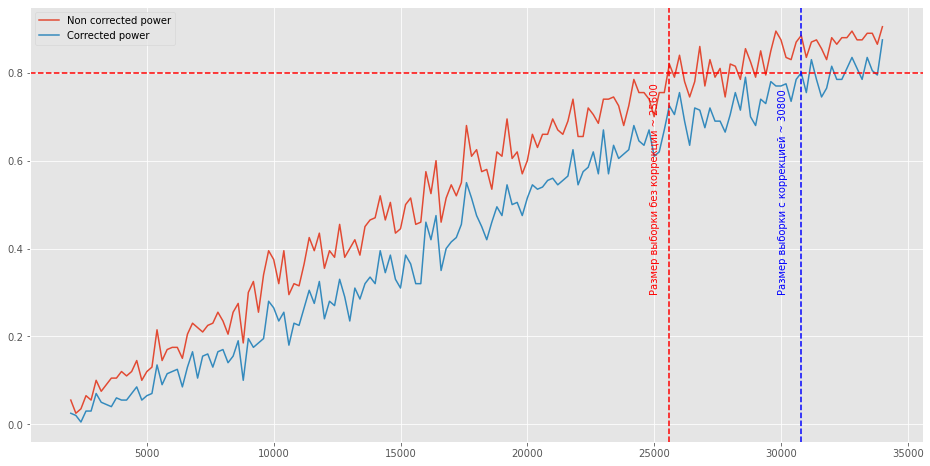

In [ ]:
find_multi_tt_sample_size(hist_data, 200, 2000, 0.2, 200, 0.8, plot = True, method = 'bonferroni')

In [ ]:
# для t-test нам понадобилась выборка в каждой из трех групп при попарном сравнении этих групп
mean = hist_data.mean()
std = hist_data.std()
rel_effect = 0.2
effect_size = mean*rel_effect / std
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, nobs1=None, alternative = 'two-sided'))#
sample_size

18307